## Chapter 2-3, 1강 시계열 데이터 이해 및 분석 — Bike Sharing (Hourly)

- **목표**: 시계열 데이터의 기본 특성을 이해하고, 전처리·시각화·계절성·보간법·주기성·이상치 실습합니다.
- **데이터**: Kaggle Bike Sharing Demand (시간 단위, `count` 대상)
- **규칙(강의용)**: `matplotlib`만 사용 (seaborn 사용 X), 색상 지정 X, 서브플롯 X

#### 구성
- 데이터 로딩과 점검: 시간 간격/누락/중복
- 집계와 시각화: 시간→일/주 변환, 캘린더 히트맵, 범주별 박스플롯
- 영향 요인 탐색: 근무일/주말/공휴일, 날씨 변수와 비선형(LOWESS)
- 전체적 트렌드 및 계절성 분석: 이동통계, STL


> 이 노트북은 학습 목적의 EDA 흐름을 단계별로 보여주며, 각 코드 블록 앞뒤에 상세 설명을 제공합니다.


### 0. 환경 준비 및 라이브러리 임포트

- 시각화는 `matplotlib`만 사용합니다.
- 통계적 정상성/계절성 분석을 위해 `statsmodels` 모듈을 사용합니다.
- 재현성과 간단한 수치 처리를 위해 `numpy`, `pandas`를 사용합니다.


In [1]:
# -*- coding: utf-8 -*-
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

from statsmodels.tsa.seasonal import STL
from statsmodels.nonparametric.smoothers_lowess import lowess

# 전역 경고 억제 (미래/폐기 예정 경고 및 폰트 경고 노이즈 제거)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message=r"Glyph.*missing from font.*", category=UserWarning)

# 한글 폰트 설정 및 마이너스 기호 깨짐 방지 (후보군을 sans-serif 우선순위로 지정)
def _set_korean_font() -> None:
    font_candidates = [
        "AppleGothic",
        "NanumGothic",
        "Malgun Gothic",
        "Noto Sans CJK KR",
        "Noto Sans KR",
        "DejaVu Sans",
    ]
    # 우선순위 리스트를 그대로 등록하여 사용 가능한 항목으로 대체되도록 함
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = font_candidates
    plt.rcParams["axes.unicode_minus"] = False

_set_korean_font()

# 노트북 전체 표시 옵션
pd.set_option('display.max_columns', 50)



#### 안내: 경고 억제와 한글 폰트
- 본 노트북은 시연의 가독성을 위해 Future/Deprecation 경고를 숨겼습니다.
- macOS/Windows/Noto 계열 폰트를 순차 탐색하여 한글이 깨지지 않도록 설정했습니다.


### 1. 데이터 불러오기와 기본 전처리

- `train.csv` 파일을 현재 디렉토리 또는 `./data/train.csv`, `/mnt/data/train.csv` 위치에서 탐색하여 읽습니다.
- `datetime`을 시계열로 파싱하고 정렬합니다.
- 강의에 필요한 열 순서를 고정합니다.


In [2]:
def load_data():
    """
    Bike Sharing Demand 학습용 데이터(`train.csv`)를 다음 경로에서 로드합니다.
    - 이 강의 저장소 구조: 'bike-sharing-demand/train.csv'

    반환 값:
        pandas.DataFrame: datetime 파싱과 열 정렬을 마친 데이터프레임
    """
    candidates = [
        'bike-sharing-demand/train.csv'
    ]
    path = None
    for c in candidates:
        if os.path.exists(c):
            path = c
            break
    if path is None:
        raise FileNotFoundError(
            "train.csv 경로를 찾을 수 없습니다."
        )

    df = pd.read_csv(path)
    # 1) 타입 처리: datetime 컬럼을 시계열로 파싱
    df['datetime'] = pd.to_datetime(df['datetime'])
    # 2) 시간 정렬 및 인덱스 초기화
    df = df.sort_values('datetime').reset_index(drop=True)
    # 3) 강의에 필요한 열 순서 고정
    cols = [
        'datetime','season','holiday','workingday','weather',
        'temp','atemp','humidity','windspeed','casual','registered','count'
    ]
    df = df[cols]
    return df

# 로드 및 기본 정보 출력
df = load_data()
print("데이터 크기:", df.shape)
print("기간:", df['datetime'].min(), "→", df['datetime'].max())
print(df.head(3))


데이터 크기: (10886, 12)
기간: 2011-01-01 00:00:00 → 2012-12-19 23:00:00
             datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  


| **컬럼명**      | **데이터 내용**                                   |
|------------------|--------------------------------------------------|
| **Datetime**     | 시간 (YYYY-MM-DD 00:00:00)                       |
| **Season**       | 봄(1), 여름(2), 가을(3), 겨울(4)                 |
| **Holiday**      | 공휴일(1), 그외(0)                               |
| **Workingday**   | 근무일(1), 그외(0)                               |
| **Weather**      | 아주 깨끗한 날씨(1), 약간의 안개와 구름(2), 약간의 눈·비(3), 아주 많은 비와 우박(4) |
| **Temp**         | 온도 (섭씨로 주어짐)                             |
| **Atemp**        | 체감 온도 (섭씨로 주어짐)                        |
| **Humidity**     | 습도                                             |
| **Windspeed**    | 풍속                                             |
| **Casual**       | 비회원의 자전거 대여량                           |
| **Registered**   | 회원의 자전거 대여량                             |
| **Count**        | 총 자전거 대여량 (비회원 + 회원)                 |

#### 왜 이 단계가 필요한가?
- **시계열 분석의 출발점**은 시간 열(`datetime`)이 올바른 타입과 순서로 정리되는 것입니다.
- Kaggle 원본 컬럼 구성 상, 분석에 쓰지 않는 컬럼은 없지만 강의에서는 학습 흐름을 위해 열 순서를 고정합니다.
- 출력으로 데이터 크기/기간/앞부분을 확인해 전체 범위와 시간 해상도를 감 잡습니다.


### 2. 시간 간격/결측/중복 체크

- 중복된 시각이 있는지 확인합니다.
- 실제 데이터의 간격 분포를 확인해 대표적 간격(top3)을 출력합니다.
- 기준 주기(여기서는 hourly)를 가정해 누락된 타임스탬프 개수를 계산합니다.

> 이 단계는 이후 보간·리샘플링 및 모델링 가정(정규 간격)에 대해 점검하는 역할을 합니다.


In [3]:
def check_time_gaps(data: pd.DataFrame) -> None:
    """
    시계열 품질 점검: 중복, 간격 빈도, 누락 개수 출력
    Args:
        data: 'datetime' 컬럼을 포함한 원본 DataFrame
    """
    # 1) 중복 개수
    dup = data['datetime'].duplicated().sum()
    print("중복 datetime 개수:", dup)

    # 2) 시간 간격 빈도 상위
    diffs = data['datetime'].diff().dropna()
    print("가장 흔한 간격(top 3):")
    print(diffs.value_counts().head(3))

    # 3) 누락된 타임스탬프 개수 (정규 hourly 가정)
    # 'datetime' 컬럼의 최소값부터 최대값까지, 시간 단위('h')로 연속적인 타임스탬프 생성
    full = pd.date_range(start=data['datetime'].min(), end=data['datetime'].max(), freq='h')
    # 생성된 연속적인 타임스탬프(full)에서 실제 데이터의 타임스탬프(data['datetime'])를 제외하여 누락된 시간 계산
    missing = np.setdiff1d(full.values, data['datetime'].values)
    print("누락된 시간 개수:", len(missing))

check_time_gaps(df)


중복 datetime 개수: 0
가장 흔한 간격(top 3):
datetime
0 days 01:00:00     10820
0 days 02:00:00        36
12 days 01:00:00       13
Name: count, dtype: int64
누락된 시간 개수: 6370


### 3. 인덱스 설정 및 리샘플링(시간→일/주)

- `datetime`을 인덱스로 설정하면 시계열 연산이 간단해집니다.
- 시간단위 수요(`count`)를 일/주 단위 평균으로 변환하여 큰 흐름(추세, 계절)을 확인합니다.

> 리샘플링은 추후 정상성 검사, 계절성 분석(STL/ACF) 등과 연결됩니다.


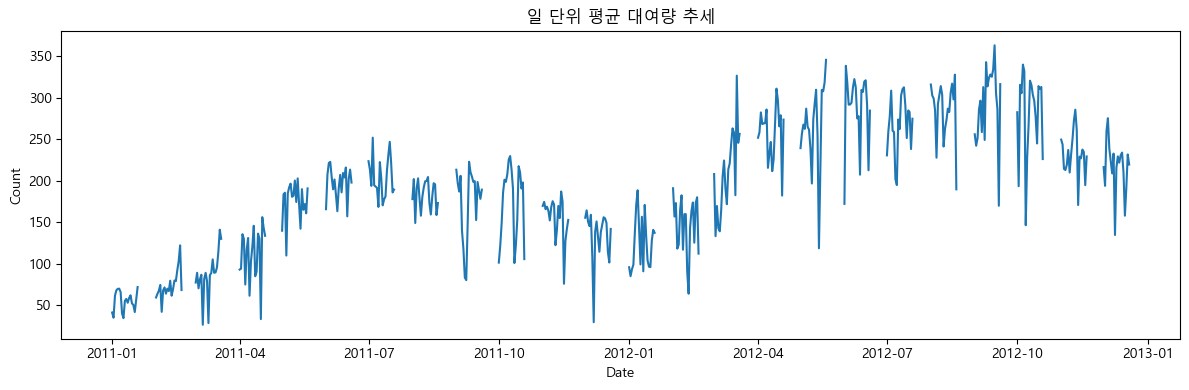

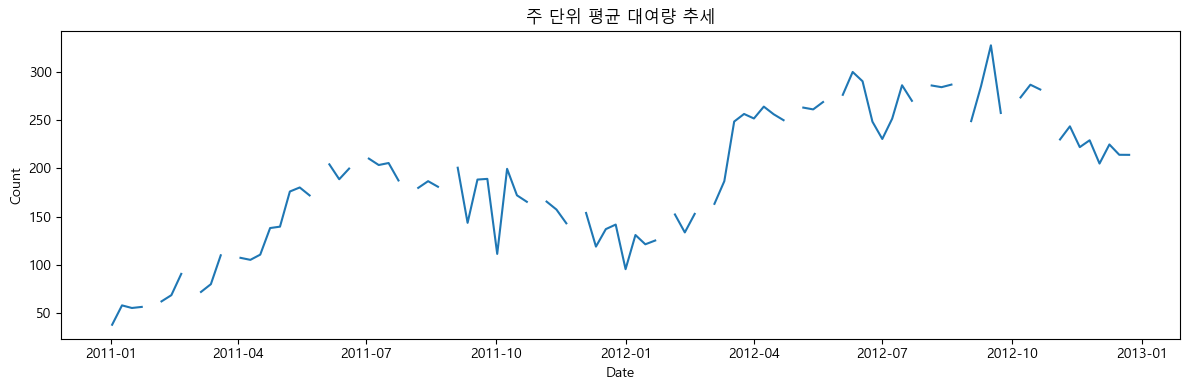

In [4]:
# 시계열 인덱스 설정
_df = df.set_index('datetime')

# 집계 및 시각화 함수
def resample_and_plot(series: pd.Series, rule: str, title: str) -> pd.Series:
    """
    시리즈를 주어진 규칙으로 집계(mean)하고 단일 선 그래프로 시각화합니다.
    Args:
        series: 시계열 Series (DatetimeIndex)
        rule: 리샘플 규칙('D','W' 등)
        title: 플롯 제목
    Returns:
        pd.Series: 리샘플된 평균 시리즈
    """
    agg = series.resample(rule).mean()
    plt.figure(figsize=(12,4))
    plt.plot(agg.index, agg.values)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    return agg

hourly = _df['count']
daily = resample_and_plot(hourly, 'D', '일 단위 평균 대여량 추세')
weekly = resample_and_plot(hourly, 'W', '주 단위 평균 대여량 추세')


#### 해설: 인덱스 설정 및 리샘플링(일/주)
- 목적: 시간 해상도를 낮춰 큰 흐름을 파악하고 변동성/계절성 확인.
- 해석 체크포인트:
  - 일 평균: 주기적 파형(주간/연간)이 시각적으로 드러납니다.
  - 주 평균: 장기 추세와 계절 요인 분리가 더 쉬워집니다.
  - 급격한 봉우리/골은 이벤트/기상 요인 가능성이 큽니다.


### 4. 달력(Weekday × Week) 히트맵

- 월별로 주차(week-of-month) × 요일(weekday) 그리드를 만들어, 일 평균 대여량의 달력 패턴을 직관적으로 확인합니다.
- 색상 지정 없이 기본 `imshow`를 사용합니다.

> 해석 팁: 특정 월/요일 조합에서 평균 수요가 상대적으로 높거나 낮은 구간이 보이면, 업무일/주말/휴일 효과와도 연계해볼 수 있습니다.


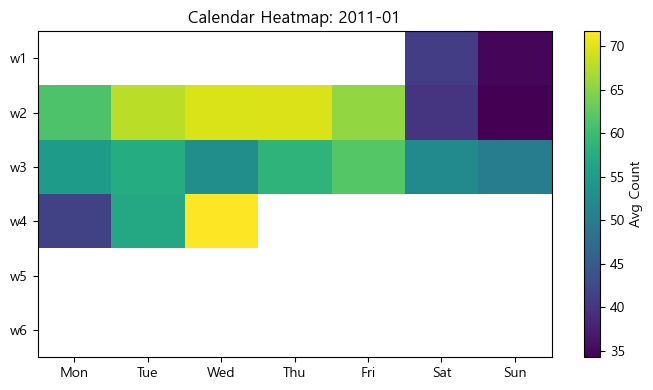

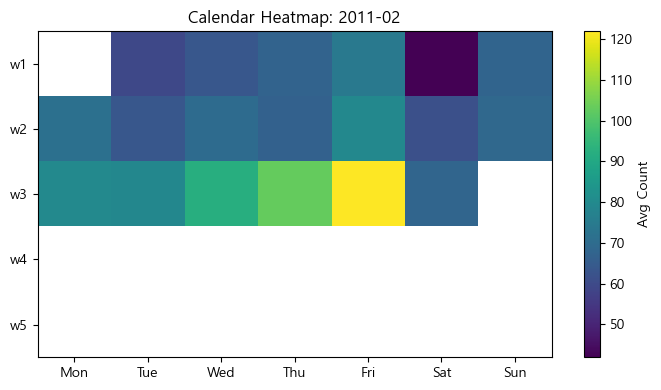

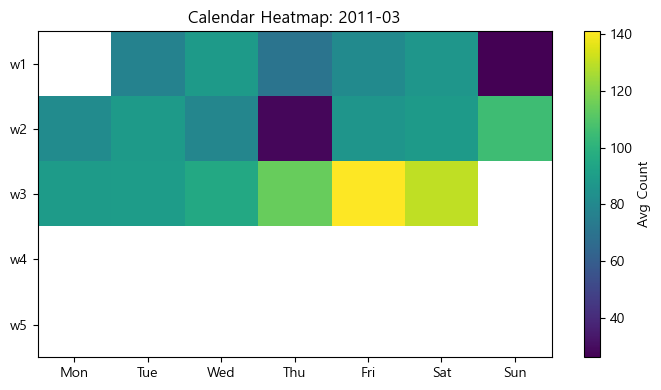

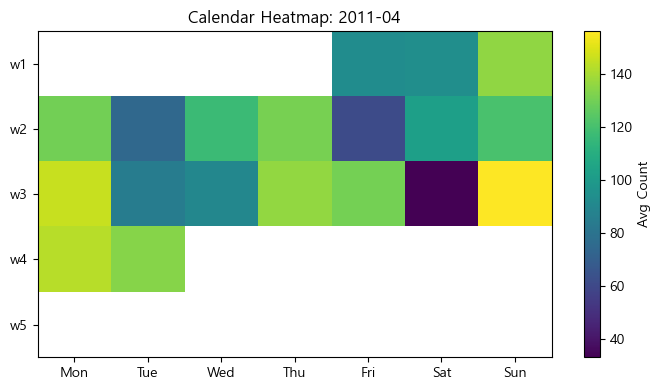

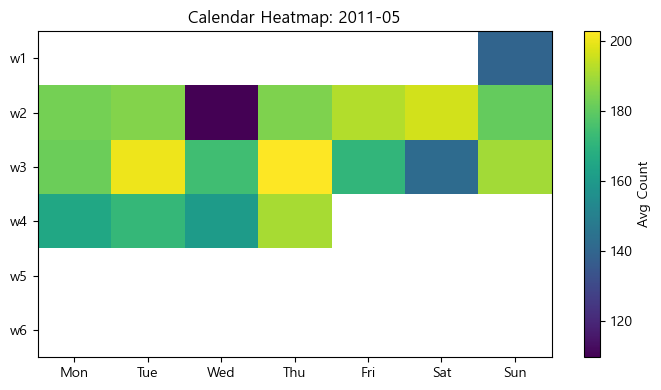

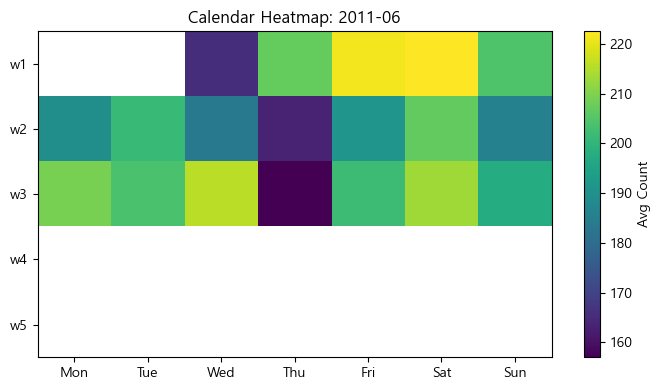

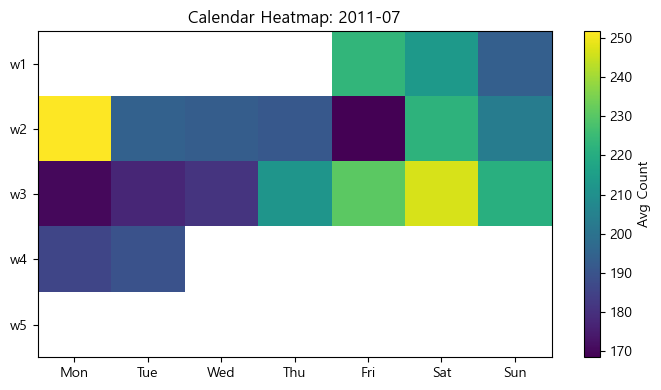

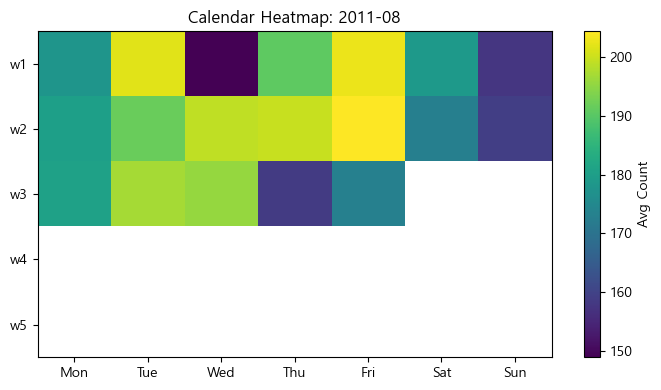

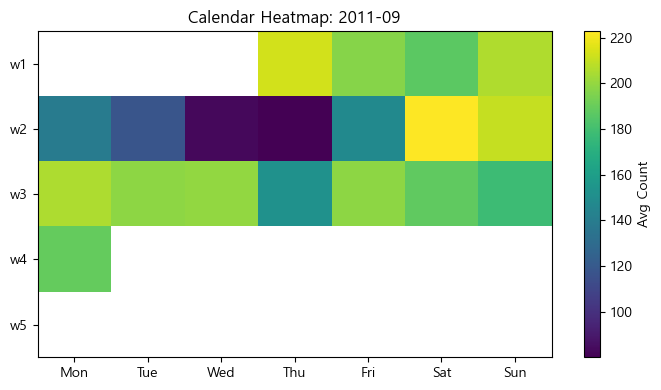

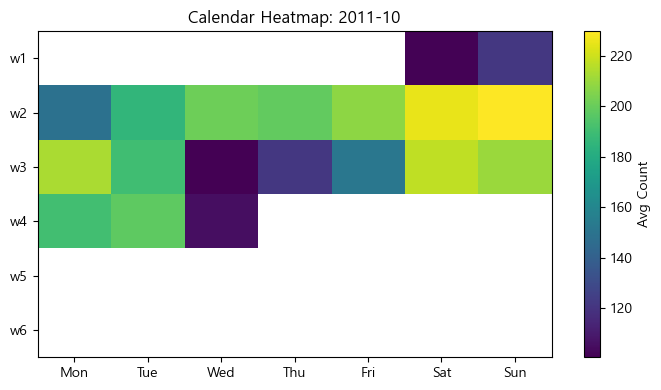

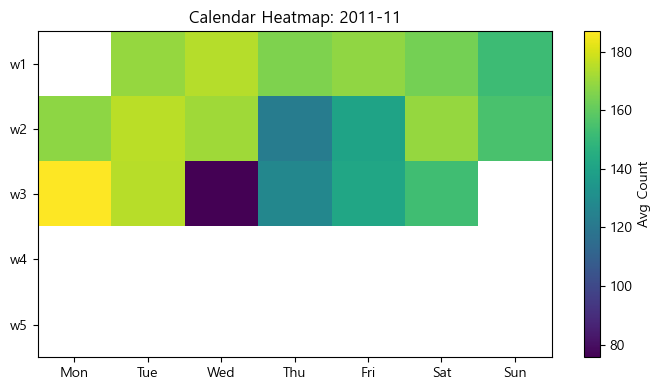

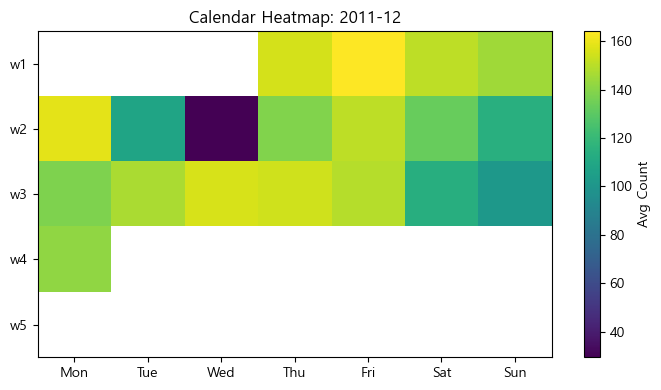

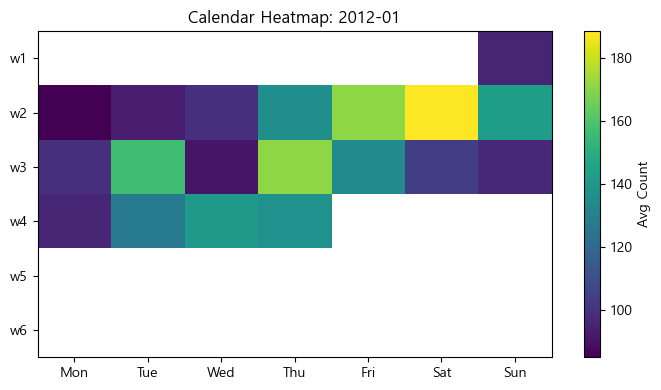

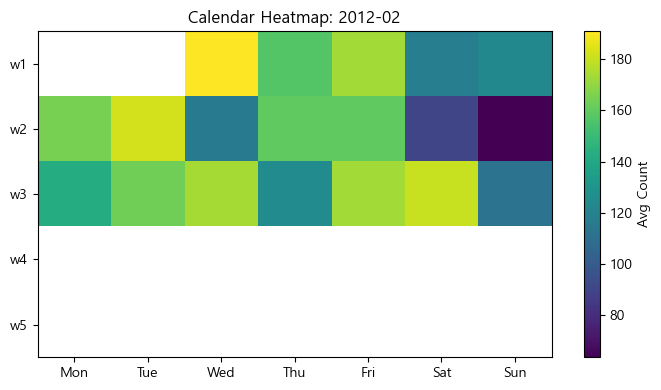

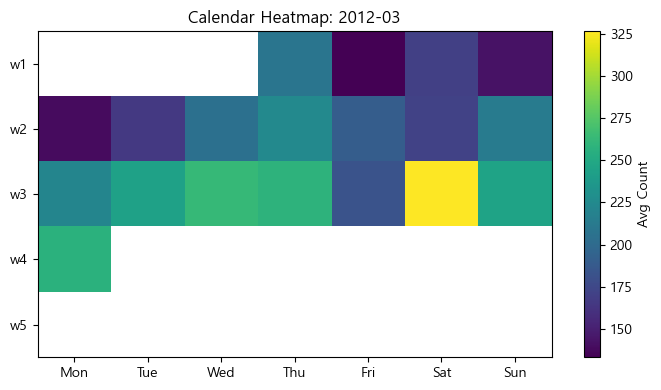

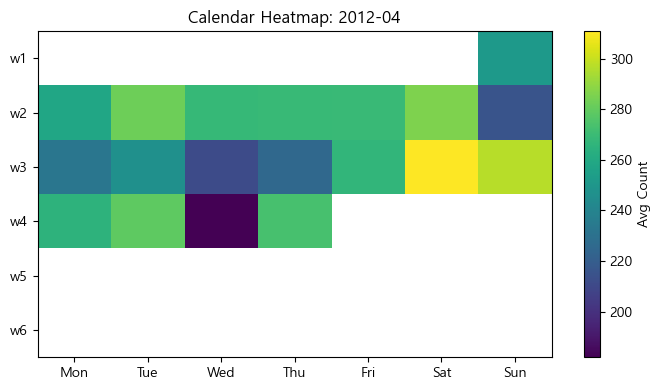

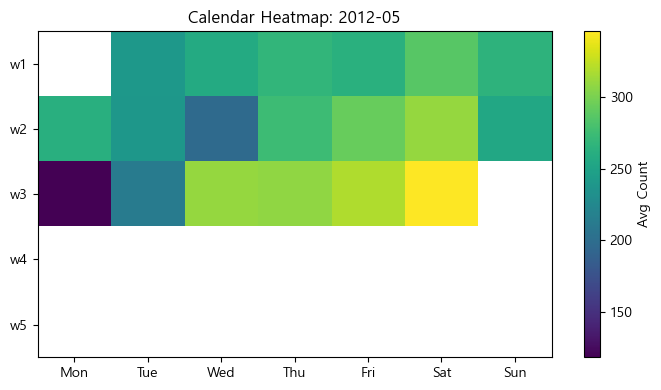

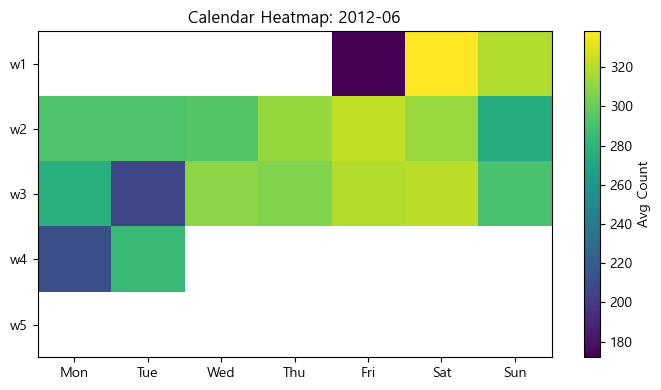

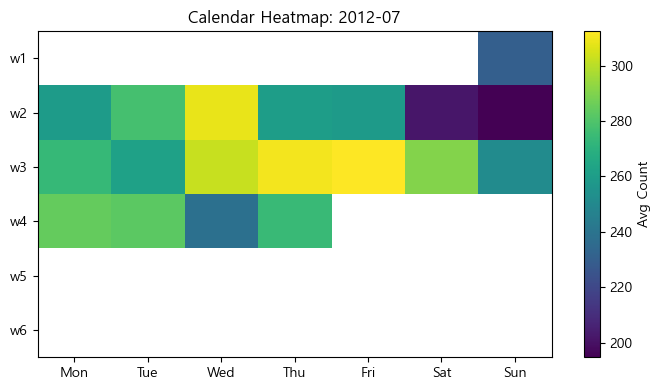

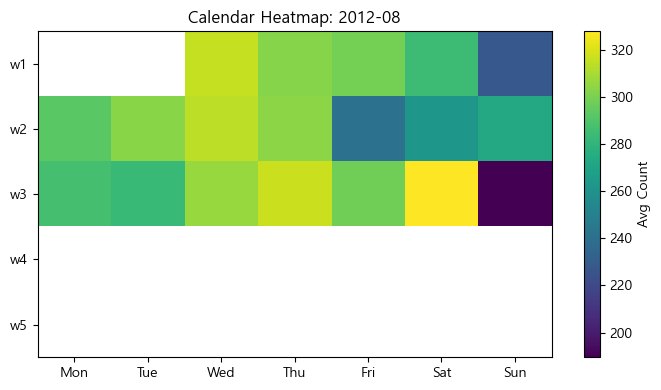

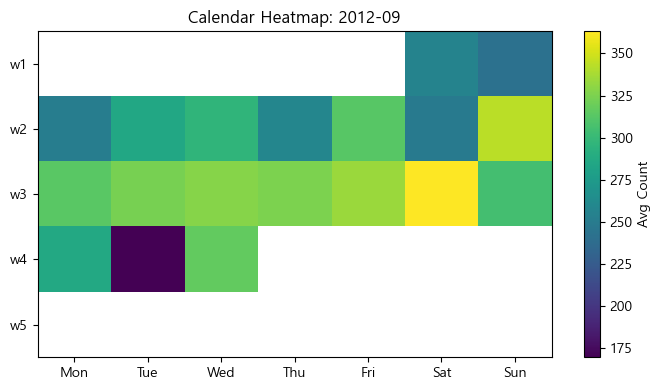

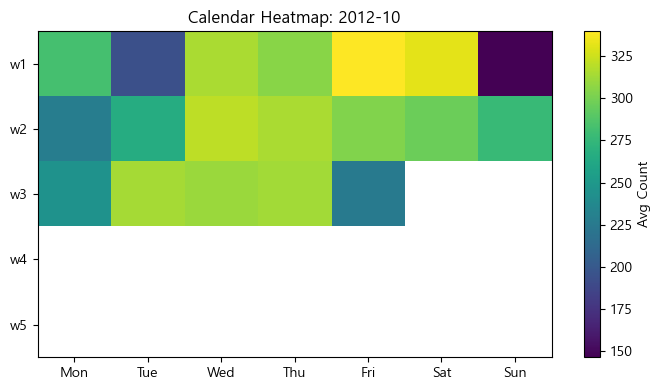

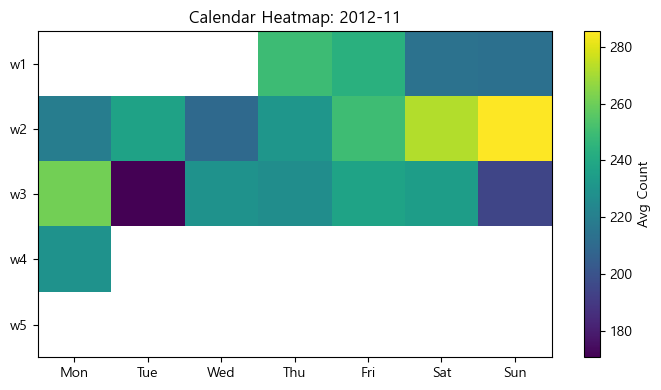

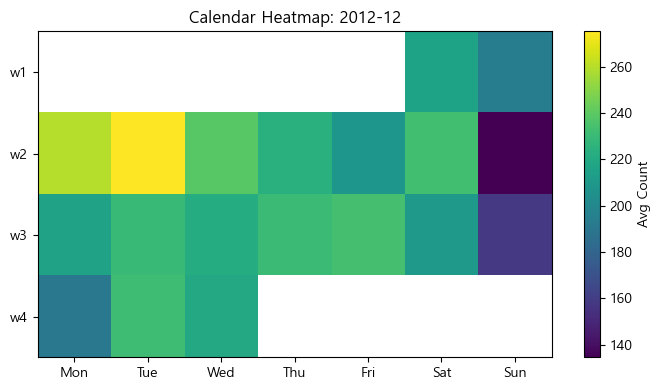

In [5]:
def calendar_heatmap_daily(daily_series: pd.Series) -> None:
    """
    월별 캘린더 히트맵: (week_of_month x weekday) 매트릭스로 일 평균 대여량 시각화
    - 월별 실제 최대 주차까지만 표시(w5/w6는 해당 월에 필요할 때만 표시)
    - 결측 셀(NaN)은 별도 색상(회색)으로 시각화하여 인지 가능하게 표시
    Args:
        daily_series: 일 단위 평균 시리즈 (DatetimeIndex, 빈도 불필요)
    """
    from matplotlib.patches import Patch

    s = daily_series.copy()
    dti = s.index
    year_month = dti.to_period('M')

    for ym, ss in s.groupby(year_month):
        if ss.empty:
            continue
        first = ss.index.min()
        # 월 내 각 날짜의 주차(0-base) 계산 후 최대 주차 결정
        week_idxs = [((d.day + first.weekday() - 1) // 7) for d in ss.index]
        max_weeks = max(week_idxs) + 1  # 표시할 실제 행 수
        cal = pd.DataFrame(index=range(max_weeks), columns=range(7), dtype=float)

        # 각 날짜를 (주차, 요일) 좌표에 배치
        for d, val in ss.items():
            week_of_month = ((d.day + first.weekday() - 1) // 7)
            cal.loc[week_of_month, d.weekday()] = val

        # # 결측값을 마스크하여 별도 색으로 표시
        data = np.ma.masked_invalid(cal.values)
        cmap = plt.cm.viridis.copy()
        # cmap.set_bad(color='lightgray', alpha=0.7)  # 결측: 회색

        plt.figure(figsize=(7,4))
        plt.imshow(data, cmap=cmap, aspect='auto', interpolation='nearest')
        plt.title(f'Calendar Heatmap: {ym}')
        plt.yticks(range(max_weeks), [f'w{i + 1}' for i in range(max_weeks)])
        plt.xticks(range(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
        plt.colorbar(label='Avg Count')
        # 결측 범례 추가
        #missing_patch = Patch(facecolor='lightgray', edgecolor='none', label='결측')
        #plt.legend(handles=[missing_patch], loc='upper right', frameon=False)
        plt.tight_layout()
        plt.show()

calendar_heatmap_daily(daily)


#### 해설: 캘린더 히트맵
- 목적: 월별 요일×주차 패턴을 한 화면에서 확인.
- 해석:
  - 평일과 주말의 평균 강도 차이가 격자로 뚜렷이 구분됩니다.
  - 월초/월말의 비정상 구간은 결측/이벤트/기상 이슈 점검 포인트입니다.


### 5. 범주별 박스플롯(연/월/요일/시간)

- 연/월/요일/시간대에 따른 `count`의 분포를 비교해 이상값과 분산 차이를 직관적으로 파악합니다.
- `matplotlib`의 `boxplot`을 사용합니다(색상/스타일 지정 없이 기본값).


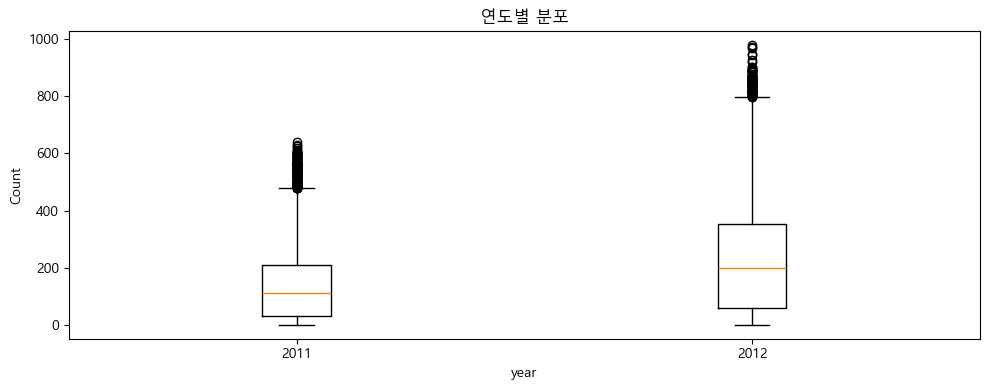

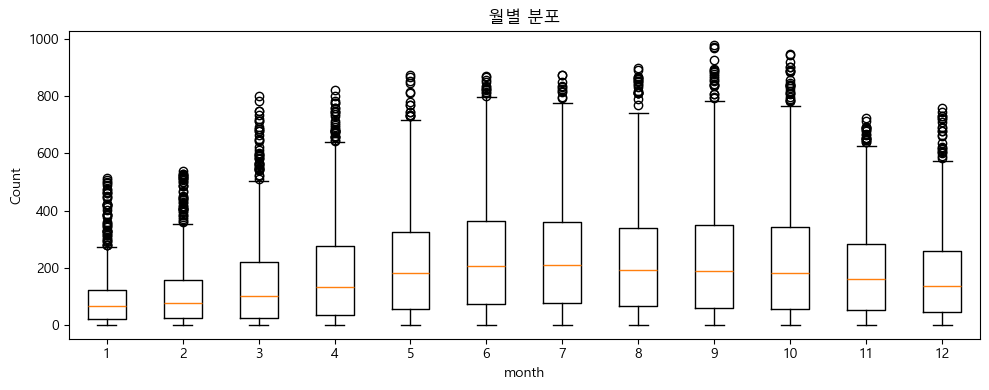

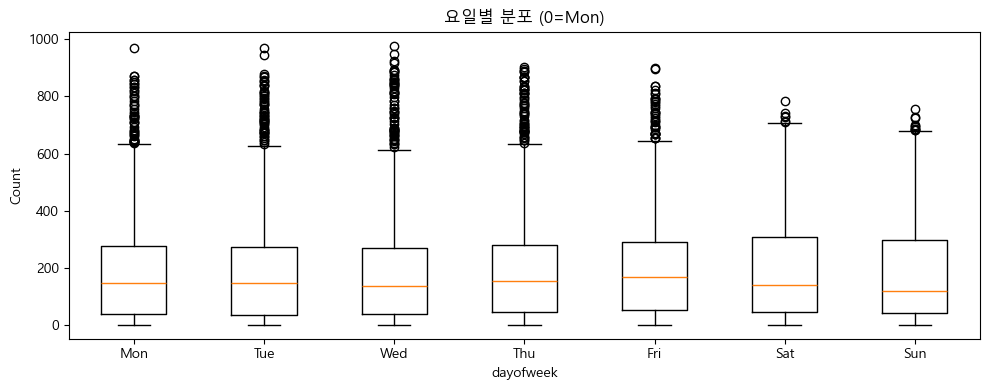

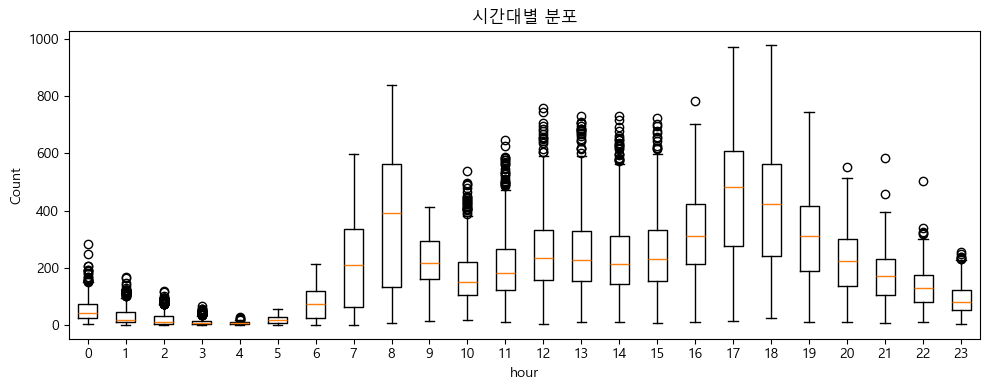

In [6]:
def boxplot_by_category(df_reset: pd.DataFrame, col: str, title: str, labels=None) -> None:
    plt.figure(figsize=(10,4))

    # 범주형 컬럼(col)별로 그룹화하여 'count' 값을 추출
    groups = [g['count'].values for _, g in df_reset.groupby(col)]

    # 박스플롯 생성 (이상치 표시 활성화: showfliers=True)
    plt.boxplot(groups, showfliers=True)

    # x축 레이블 설정 (labels가 없으면 컬럼의 고유값을 정렬하여 사용)
    if labels is None:
        labels = sorted(df_reset[col].unique())
    plt.xticks(range(1, len(groups)+1), labels, rotation=0)

    # 그래프 제목, x축, y축 레이블 설정
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel('Count')
    
    # 레이아웃 조정
    plt.tight_layout()
    plt.show()

# 파생 범주 추가 및 박스플롯 실행
df_reset = _df.reset_index()
df_reset['year'] = df_reset['datetime'].dt.year
df_reset['month'] = df_reset['datetime'].dt.month
df_reset['dayofweek'] = df_reset['datetime'].dt.dayofweek
df_reset['hour'] = df_reset['datetime'].dt.hour

boxplot_by_category(df_reset, 'year', '연도별 분포')
boxplot_by_category(df_reset, 'month', '월별 분포', labels=list(range(1,13)))
boxplot_by_category(df_reset, 'dayofweek', '요일별 분포 (0=Mon)', labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
boxplot_by_category(df_reset, 'hour', '시간대별 분포', labels=list(range(24)))


#### 해설: 범주별 박스플롯
- 목적: 범주(연/월/요일/시간)별 분포(중앙값·사분위·이상치) 비교.
- 해석:
  - 연도: 분포가 연차에 따라 상향/하향하는지 확인해 구조적 변화 여부를 검토.
  - 월: 계절성(여름↑ 겨울↓)이 박스 높이로 드러납니다.
  - 요일: 근무일 중앙값이 주말 대비 높은 경향.
  - 시간: 출퇴근 피크와 심야 저점이 분명합니다.


#### 자전거 대여 데이터 분포 분석

#### 1) 연도별 분포
- **2011년**
  - 중앙값: 약 100
  - 대부분 0~200 구간에 분포
  - 400 이상에서도 이상치 다수 존재
- **2012년**
  - 중앙값: 약 200 (2011년 대비 상승)
  - 분산이 커지고 이상치 더 많음

#### 요약 : 2012년에 전반적으로 대여량이 증가하고, 피크도 더 커졌음을 의미함.

---

#### 2) 월별 분포
- 겨울(1~2월): 중앙값 낮음, 전체적으로 이용량 적음
- 봄~여름(4~9월): 중앙값 지속 상승, 특히 6~9월이 최댓값
- 가을~겨울(10~12월): 다시 감소

#### 요약 : 여름철이 성수기, 겨울철은 비수기.

---

#### 3) 요일별 분포
- 요일별 중앙값은 큰 차이 없음 (평일·주말 모두 유사)
- 주말(Sat, Sun): 분포가 넓고 일부 날에 대여량이 급증

#### 요약 :  평일·주말 모두 꾸준히 대여되지만, 주말에 특정 이벤트성 증가가 나타남.

---

#### 4) 시간대별 분포
- 0~5시: 대여량 거의 없음
- 7~9시: 출근 시간대 급격히 증가 (특히 8시 피크)
- 11~17시: 점심~오후에도 꾸준히 많음
- 17~19시: 퇴근 시간대 최댓값 → 하루 중 가장 높은 대여량
- 20시 이후: 점차 감소

#### 요약 :  자전거 대여는 출퇴근 시간대(8시, 18시 부근)와 낮 시간대에 집중.

---

#### 종합 해석
- 2012년에 전반적으로 대여량이 크게 늘어남  
- 계절별로 여름철이 성수기, 겨울철이 비수기  
- 요일별 차이는 크지 않으나 주말에 피크가 튐  
- 시간대는 출퇴근 시간대와 낮 시간대에 집중


### 6. 주중/주말 & 휴일 효과(평균±95% CI)

- 근무일(workingday), 주말(토·일), 공휴일(holiday) 조건에서 평균과 95% 신뢰구간을 막대로 비교합니다.
- 표본 표준오차로 근사한 CI를 사용합니다.


Workingday - 평균: 193.01, 신뢰구간: ±4.20
Weekend - 평균: 188.77, 신뢰구간: ±6.07
Holiday - 평균: 185.88, 신뢰구간: ±18.71


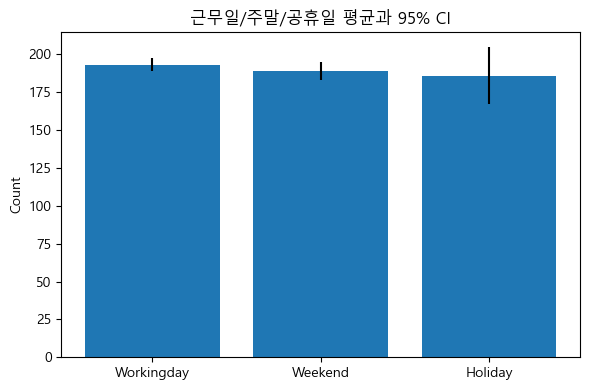

In [7]:
def mean_ci(vals: np.ndarray) -> tuple[float, float]:
    """
    주어진 값(vals)의 평균과 95% 신뢰구간(CI)을 계산합니다.
    
    Args:
        vals (np.ndarray): 입력 데이터 배열.
    
    Returns:
        tuple[float, float]: 평균(m)과 95% 신뢰구간(CI).
    """
    # 평균 계산
    m = float(np.mean(vals))
    # 표준편차 계산 (ddof=1로 표본 표준편차 사용)
    s = float(np.std(vals, ddof=1))
    n = len(vals)
    # 표준오차 계산 (표준편차 / sqrt(n))
    se = s / np.sqrt(max(n, 1))
    # 평균과 95% 신뢰구간 반환 (1.96은 정규분포의 95% 범위)
    return m, 1.96 * se

# 근무일, 주말, 공휴일 조건별 평균과 신뢰구간 계산
profiles = []
for name, cond in {
    'Workingday': df_reset['workingday'] == 1,  # 근무일 조건
    'Weekend': df_reset['dayofweek'] >= 5,     # 주말 조건 (요일이 5 이상: 토·일)
    'Holiday': df_reset['holiday'] == 1,       # 공휴일 조건
}.items():
    # 조건에 맞는 데이터에서 'count' 값을 추출하여 평균과 신뢰구간 계산
    m, ci = mean_ci(df_reset.loc[cond, 'count'].values)
    # 평균과 신뢰구간 출력
    print(f"{name} - 평균: {m:.2f}, 신뢰구간: ±{ci:.2f}")
    # 결과를 리스트에 저장
    profiles.append((name, m, ci))

# 시각화: 조건별 평균과 신뢰구간을 막대 그래프로 표시
plt.figure(figsize=(6,4))  # 그래프 크기 설정
x = np.arange(len(profiles))  # x축 위치 설정
means = [p[1] for p in profiles]  # 평균값 추출
cis = [p[2] for p in profiles]    # 신뢰구간 추출
plt.bar(x, means, yerr=cis)       # 막대 그래프 생성 (yerr로 신뢰구간 표시)
plt.xticks(x, [p[0] for p in profiles])  # x축 레이블 설정 (조건 이름)
plt.title('근무일/주말/공휴일 평균과 95% CI')  # 그래프 제목
plt.ylabel('Count')  # y축 레이블
plt.tight_layout()  # 레이아웃 조정
plt.show()  # 그래프 표시


#### 해설: 근무일/주말/공휴일 평균±CI
- 목적: 단순 집단 비교로 수요 레벨 차이를 검증.
- 해석:
  - Workingday - 평균: 193.01, 신뢰구간: ±4.20
    - 평균: 근무일에 자전거 대여량의 평균은 약 193.01입니다.
    - 신뢰구간(CI): ±4.20은 95% 신뢰구간으로, 근무일의 평균 대여량이 188.81 ~ 197.21 사이에 있을 가능성이 높다는 것을 의미합니다.
    - 의미: 근무일에는 자전거 대여량이 비교적 안정적이며, 변동성이 적습니다.
  
  - Weekend - 평균: 188.77, 신뢰구간: ±6.07
    - 평균: 주말에 자전거 대여량의 평균은 약 188.77입니다.
    - 신뢰구간(CI): ±6.07은 95% 신뢰구간으로, 주말의 평균 대여량이 182.70 ~ 194.84 사이에 있을 가능성이 높습니다.
    - 의미: 주말에는 근무일보다 약간 적은 대여량을 보이며, 변동성이 근무일보다 조금 더 큽니다.

  - Holiday - 평균: 185.88, 신뢰구간: ±18.71
    - 평균: 공휴일에 자전거 대여량의 평균은 약 185.88입니다.
    - 신뢰구간(CI): ±18.71은 95% 신뢰구간으로, 공휴일의 평균 대여량이 167.17 ~ 204.59 사이에 있을 가능성이 높습니다.
    - 의미: 공휴일에는 자전거 대여량의 변동성이 매우 크며, 데이터가 불규칙적일 가능성이 있습니다.

### 7. 날씨 변수와 수요의 비선형 관계(LOWESS)

- `temp`, `humidity`, `windspeed`와 `count`의 비선형 관계를 LOWESS로 부드럽게 시각화합니다.
- 점 산점도와 함께 LOWESS 곡선을 겹쳐 변동성과 경향을 동시에 확인합니다.


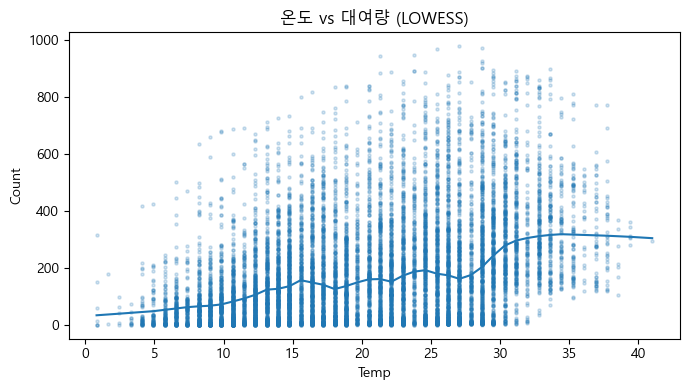

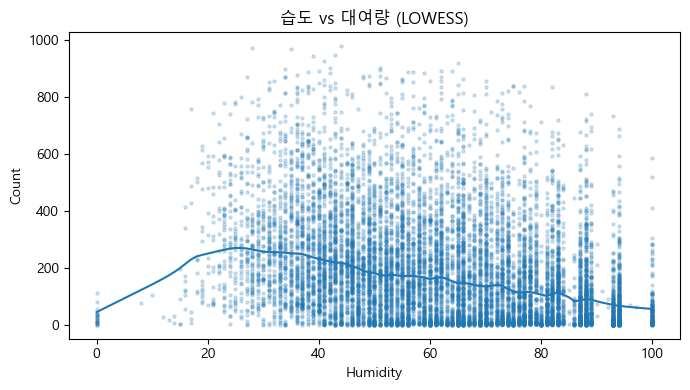

c:\Users\Administrator\Desktop\metacode-lecture\.venv\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


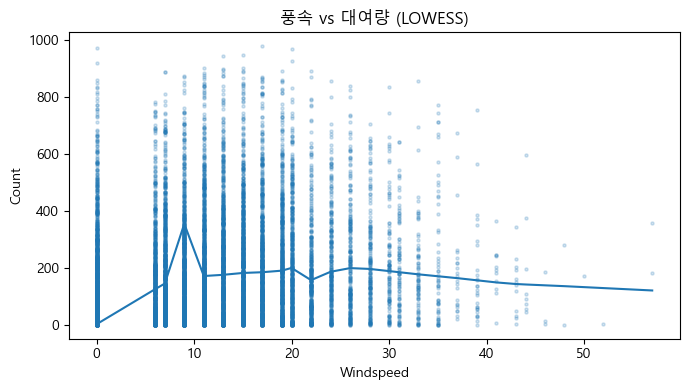

In [8]:
def scatter_lowess(x: np.ndarray, y: np.ndarray, xlabel: str, title: str) -> None:
    """
    LOWESS(Locally Weighted Scatterplot Smoothing)를 사용하여 x와 y의 관계를 시각화합니다.
    산점도와 LOWESS 곡선을 함께 표시합니다.

    Args:
        x (np.ndarray): 독립 변수 데이터 (예: 온도, 습도, 풍속 등).
        y (np.ndarray): 종속 변수 데이터 (예: 자전거 대여량).
        xlabel (str): x축 레이블.
        title (str): 그래프 제목.
    """
    # 1. 결측값(NaN) 및 무한값(Inf)을 제거하기 위한 마스크 생성
    mask = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
    
    # 2. 마스크를 적용하여 깨끗한 데이터 추출
    x_clean = x[mask]
    y_clean = y[mask]
    
    # 3. x 데이터를 정렬하여 LOWESS 곡선 계산에 사용
    order = np.argsort(x_clean)
    xs, ys = x_clean[order], y_clean[order]
    
    # 4. LOWESS(Locally Weighted Scatterplot Smoothing) 곡선 계산
    # frac=0.1은 데이터의 10%를 사용하여 국소적으로 회귀를 수행
    sm = lowess(ys, xs, frac=0.1, return_sorted=True)
    
    # 5. 그래프 생성
    plt.figure(figsize=(7,4))  # 그래프 크기 설정
    plt.scatter(xs, ys, s=5, alpha=0.2)  # 산점도 생성 (투명도 설정)
    plt.plot(sm[:,0], sm[:,1])  # LOWESS 곡선 추가
    plt.title(title)  # 그래프 제목 설정
    plt.xlabel(xlabel)  # x축 레이블 설정
    plt.ylabel('Count')  # y축 레이블 설정
    plt.tight_layout()  # 레이아웃 조정
    plt.show()  # 그래프 표시

# LOWESS를 사용하여 온도, 습도, 풍속과 자전거 대여량의 관계를 시각화
scatter_lowess(df_reset['temp'].values, df_reset['count'].values, 'Temp', '온도 vs 대여량 (LOWESS)')
scatter_lowess(df_reset['humidity'].values, df_reset['count'].values, 'Humidity', '습도 vs 대여량 (LOWESS)')
scatter_lowess(df_reset['windspeed'].values, df_reset['count'].values, 'Windspeed', '풍속 vs 대여량 (LOWESS)')


#### LOWESS(Locally Weighted Scatterplot Smoothing, 로컬 가중 회귀 스무딩)
 - 데이터를 부드럽게 표현하기 위한 비모수적 회귀 기법입니다. 
 - 특히 시계열이나 산점도에서 데이터의 전체적인 추세(Trend)를 파악할 때 많이 씁니다.

##### 날씨 요인과 자전거 대여량 (LOWESS 분석)
##### 1) 온도(Temp) vs 대여량(Count)
**패턴**  
- 온도가 오를수록 대여량이 증가하다가, 약 **30도 부근 이후부터는 오히려 감소**  

**해석**  
- 추운 날씨(0~10도): 대여량이 적음  
- 따뜻한 날씨(10~25도): 자전거 이용 활발  
- 더운 날씨(30도 이상): 대여량 감소  
- **적당히 따뜻할 때 가장 많이 탄다**는 패턴  

---

#### 2) 습도(Humidity) vs 대여량(Count)
**패턴**  
- 습도가 낮을 때(0~30%) 대여량이 많고, 습도가 높아질수록 점차 감소  

**해석**  
- 건조하거나 쾌적한 날씨에 대여량 많음  
- 습도가 높아지면 불쾌지수 상승 → 활동량 감소 → 대여량 감소  
- 특히 **습도 60% 이상부터 뚜렷한 하락세**  

---

#### 3) 풍속(Windspeed) vs 대여량(Count)
**패턴**  
- 풍속이 약할 때(0~10) 대여량이 가장 많고, 바람이 강해질수록 점차 감소  

**해석**  
- 바람이 약하거나 적당할 때 자전거 타기 좋음  
- 풍속이 강해질수록(특히 30 이상) 대여량 급감  
- **맞바람, 안전 문제**로 이용 감소  

---

#### 종합 해석
- **가장 많이 대여하는 날씨 조건**  
  - 온도: **20~30도 사이** (따뜻하지만 덥지 않을 때)  
  - 습도: **30% 이하** (낮거나 보통 수준)  
  - 풍속: **0~10** (약한 바람)  

- **의미**  
  - 날씨가 쾌적할수록 자전거 대여량이 증가  
  - 너무 덥거나, 습하거나, 바람이 강하면 대여량이 급격히 줄어듦  


### 8. 이동평균/이동분산 트렌드 확인

- 창(window) 크기를 정해 이동평균/이동분산을 그려 평균/분산이 시간에 따라 변하는지 확인합니다.
- 일 단위로 집계한 `daily`에 대해 `window=7`을 예시로 사용합니다.


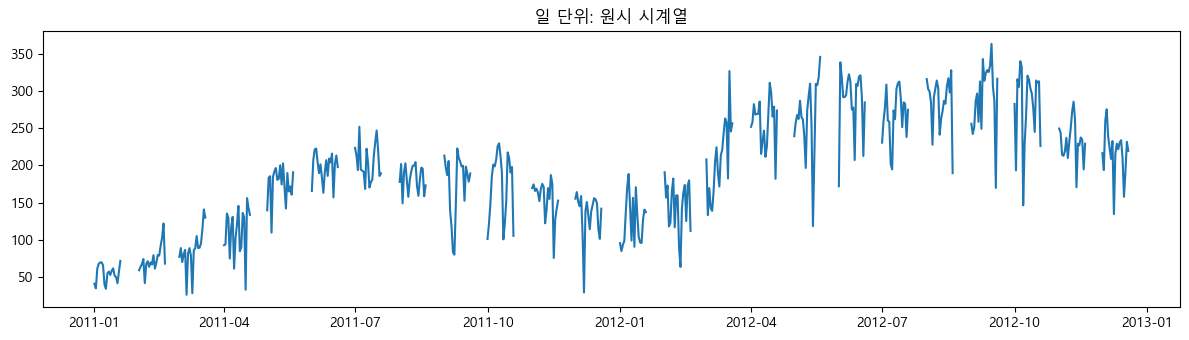

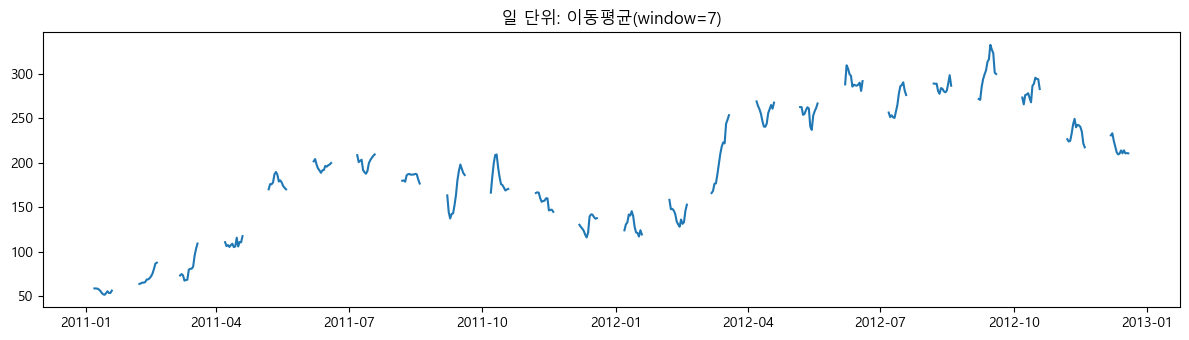

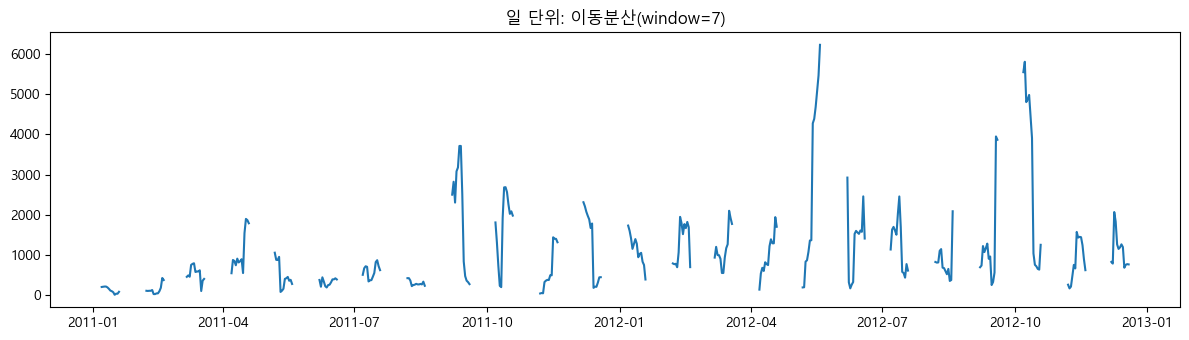

In [9]:
def rolling_stats(series: pd.Series, window: int, title_prefix: str) -> None:
    rm = series.rolling(window).mean()
    rv = series.rolling(window).var()

    plt.figure(figsize=(12,3.5))
    plt.plot(series.index, series.values)
    plt.title(f'{title_prefix}: 원시 시계열')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,3.5))
    plt.plot(rm.index, rm.values)
    plt.title(f'{title_prefix}: 이동평균(window={window})')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,3.5))
    plt.plot(rv.index, rv.values)
    plt.title(f'{title_prefix}: 이동분산(window={window})')
    plt.tight_layout()
    plt.show()

rolling_stats(daily, 7, '일 단위')


#### 시계열 데이터 분석 (원시, 이동평균, 이동분산)

##### 1) 원시 시계열
**특징**  
- 일별 변동이 크고 노이즈가 많음  
- 전반적으로 2011년 초부터 2012년 중반까지는 상승 추세, 이후 약간 하락  
- 여름·가을철에 더 높은 값이 나타나며 **계절성** 패턴 가능성  

---

##### 2) 이동평균 (window=7)
**특징**  
- 7일 단위 평균으로 노이즈를 줄여 **추세를 더 명확히 확인 가능**  
- 2011년 하반기까지 완만한 상승 → 2012년 봄~여름에 강한 증가 → 이후 하락세  
- 원시 데이터보다 전반적인 흐름(상승·하락 추세)이 뚜렷하게 보임  

---

##### 3) 이동분산 (window=7)
**특징**  
- 변동성이 큰 시점들을 강조  
- 2012년 봄, 여름, 가을에 분산이 크게 증가 → 특정 이벤트나 계절 요인 가능성  
- 분산이 낮은 구간은 **안정적인 상태**를 의미  

---

#### 종합 해석
- **원시 데이터**는 날마다 요동쳐서 해석이 어렵지만,  
- **이동평균**은 전체적인 추세(상승·하락)를 보여줌  
- **이동분산**은 특정 시점의 변동성(안정 ↔ 불안정)을 확인하는 데 유용  



### 9. 분포와 변환(log1p)

- 원시 `daily` 분포와 `log1p` 변환 후 분포를 비교해 왜도/첨도 완화를 확인합니다.
- 예측/모델링에서 로그 변환은 분산 안정화와 비선형 완화에 도움을 줄 수 있습니다.


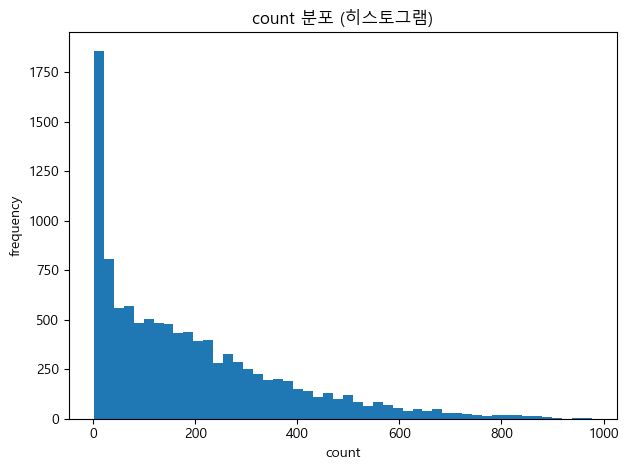

In [10]:

plt.figure()
plt.hist(df['count'], bins=50)
plt.title('count 분포 (히스토그램)')
plt.xlabel('count')
plt.ylabel('frequency')
plt.tight_layout()
plt.show()


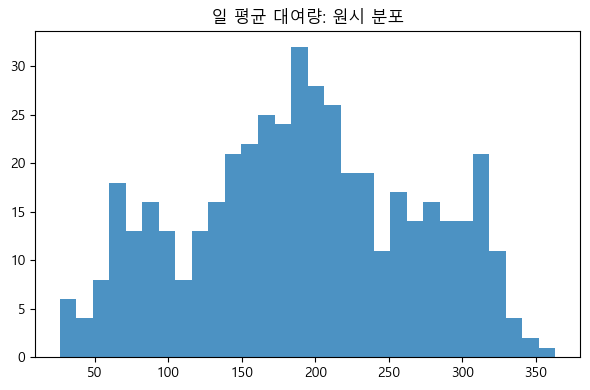

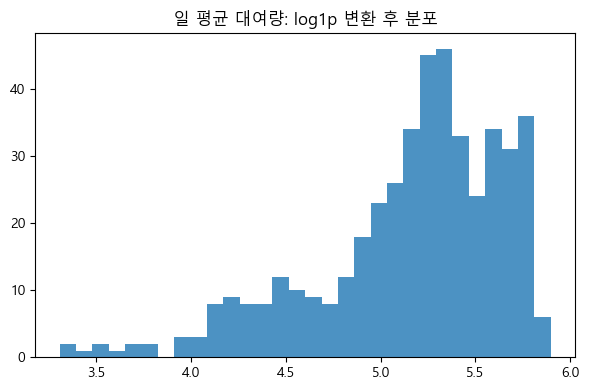

In [11]:
def hist_compare(raw: pd.Series, title_prefix: str) -> None:
    plt.figure(figsize=(6,4))
    plt.hist(raw.dropna(), bins=30, alpha=0.8)
    plt.title(f'{title_prefix}: 원시 분포')
    plt.tight_layout()
    plt.show()

    transformed = np.log1p(raw)
    plt.figure(figsize=(6,4))
    plt.hist(transformed.dropna(), bins=30, alpha=0.8)
    plt.title(f'{title_prefix}: log1p 변환 후 분포')
    plt.tight_layout()
    plt.show()

hist_compare(daily, '일 평균 대여량')


#### 해설: 분포와 log1p 변환
- 목적: 왜도/첨도 완화로 통계/모델 가정을 돕기 위함.
- 해석:
  - 원시 분포는 오른쪽 꼬리(극단적 고값)가 두드러짐.
  - log1p 변환 후 분포가 더 대칭적이 되어 회귀/ARIMA류 모델에 유리합니다.


### 10. 결측 보간 시연(FFill/Linear)

- 결측이 없더라도 실습을 위해 일부를 의도적으로 `NaN`으로 만든 후, `ffill`과 `linear` 보간을 비교합니다.
- 실제 업무에서는 결측 원인/길이/주기 성격 등을 고려해 적절한 방법을 선택해야 합니다.


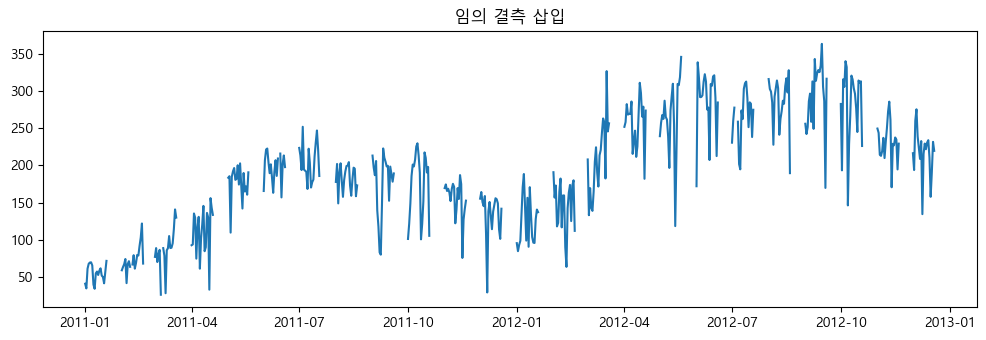

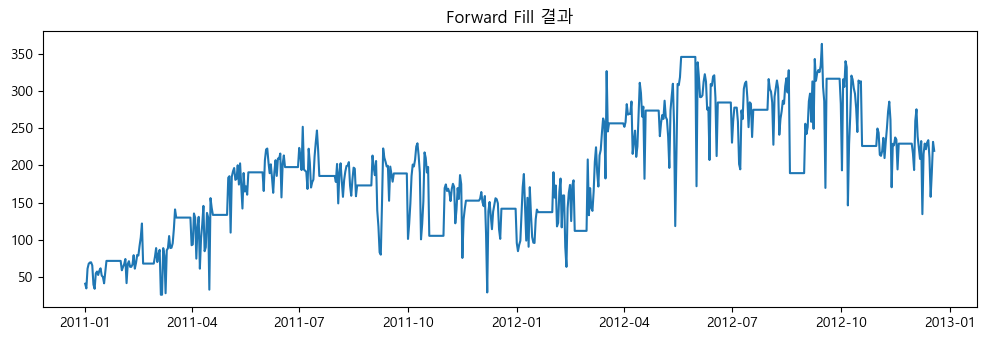

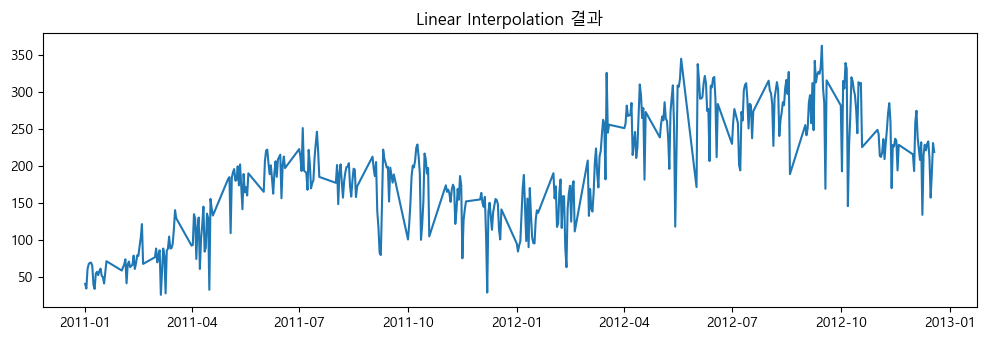

In [12]:
def imputation_demo(series: pd.Series) -> None:
    s = series.copy()
    # 임의 결측 삽입(1%)
    idx = s.sample(frac=0.01, random_state=42).index
    s.loc[idx] = np.nan

    plt.figure(figsize=(10,3.5))
    plt.plot(s.index, s.values)
    plt.title('임의 결측 삽입')
    plt.tight_layout()
    plt.show()

    ffill = s.ffill()
    plt.figure(figsize=(10,3.5))
    plt.plot(ffill.index, ffill.values)
    plt.title('Forward Fill 결과')
    plt.tight_layout()
    plt.show()

    lin = s.interpolate(method='linear')
    plt.figure(figsize=(10,3.5))
    plt.plot(lin.index, lin.values)
    plt.title('Linear Interpolation 결과')
    plt.tight_layout()
    plt.show()

imputation_demo(daily)


#### 해설: 결측 보간 시연
- 목적: 결측 처리 방법의 효과 비교.
- 해석:
  - Forward-fill: 단계형으로 직전 수준 유지. 짧은 결측에 유리.
  - Linear: 선형 추세를 보존. 긴 결측/완만한 추세 구간에 유리.
  - 주기성 데이터를 보간할 때는 seasonality-aware 방법도 고려하세요.


### 11. STL 분해(추세/계절/잔차)

- `STL`로 일 단위 시계열을 `trend`, `seasonal`, `residual`로 분해해 각 성분을 개별 플롯으로 확인합니다.
- 일별 주기(period=7)를 사용합니다.


In [13]:
def stl_components(series: pd.Series, period: int, title_prefix: str):
    # 1) 인덱스 정리
    s = series.sort_index()
    if not isinstance(s.index, pd.DatetimeIndex):
        raise ValueError("series.index는 DatetimeIndex여야 합니다.")

    # 2) 데일리로 맞추고 결측 보간(필요시 resample 로직으로 교체 가능)
    s = s.asfreq('D')
    if s.isna().any():
        s = s.interpolate('time').ffill().bfill()

    # 3) STL 적합
    res = STL(s, period=period, robust=True).fit()

    # 4) 결과를 항상 pandas Series로
    comp = {
        'Trend':    pd.Series(res.trend,    index=s.index, name='Trend'),
        'Seasonal': pd.Series(res.seasonal, index=s.index, name='Seasonal'),
        'Residual': pd.Series(res.resid,    index=s.index, name='Residual'),
    }

    # 5) 플롯
    for k, v in comp.items():
        plt.figure(figsize=(12, 3.5))
        plt.plot(v.index, v.values)
        plt.title(f'{title_prefix} {k} (period={period})')
        plt.tight_layout()
        plt.show()


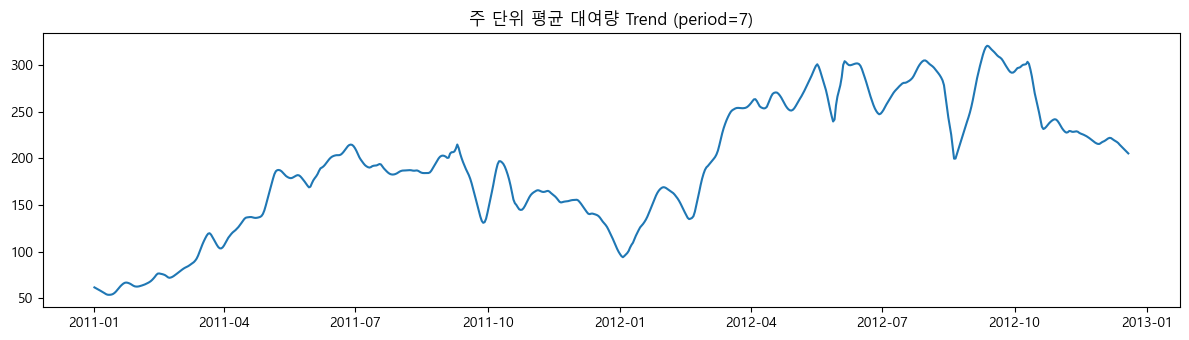

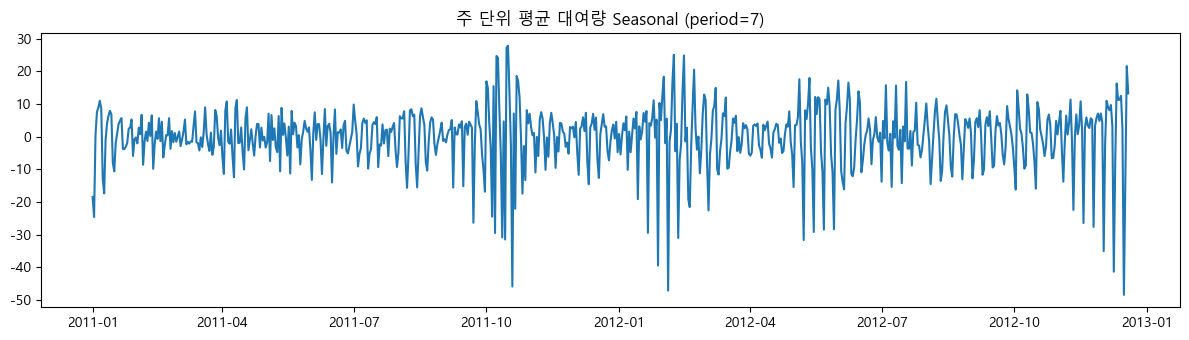

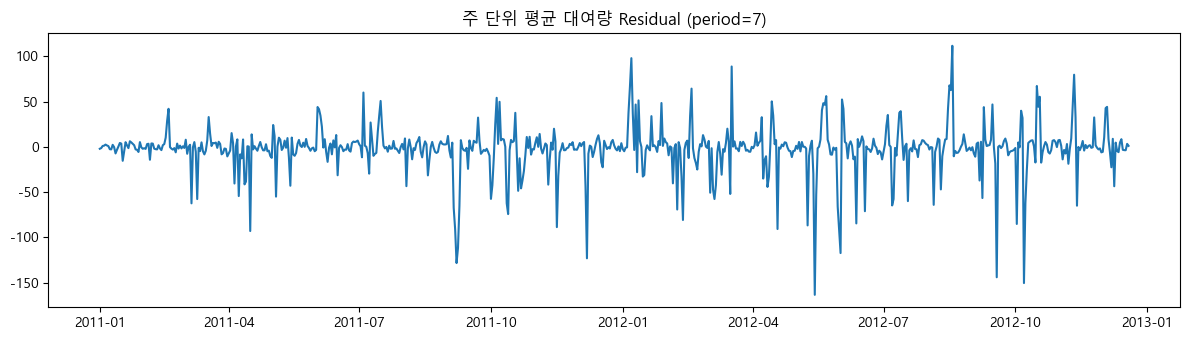

In [14]:
stl_components(daily, period=7, title_prefix='주 단위 평균 대여량')

#### STL(Trend, Seasonal, Residual) 분석

##### 1) 추세(Trend)  
**특징**  
- 2011년 초 저점 → 2012년 봄~가을에 크게 상승(주 평균 250~300대) → 2012년 말로 갈수록 완만한 하락  
- 중간에 몇 번 큰 낙폭(2011년 가을, 2012년 8~9월 일시 급락) 발생 → 단기 충격이나 휴일 구간이 추세에서 제거되며 나타난 현상 가능성  
- **해석**: 전반적으로 수요가 2012년 중반에 피크를 찍은 뒤 둔화  

---

##### 2) 계절성(Seasonal; period=7, 요일 효과)  
**특징**  
- 0을 중심으로 위아래로 진동, 진폭은 대체로 ±5 ~ ±25 사이  
- “평일↑, 주말↓(혹은 반대)”와 같은 요일별 반복 패턴 존재  
- 특정 구간(2011년 10월 전후, 2012년 초·여름)에 진폭이 확대 → 요일 효과가 계절/성수기와 상호작용하며 달라진 결과  

---

##### 3) 잔차(Residual)  
**특징**  
- 추세와 요일 효과를 제거하고 남은 이상·잡음, 평균은 0 근처  
- 곳곳에서 큰 스파이크(−150, +100 수준) 발생 → 특수 이벤트, 극단적 날씨, 공휴일 연휴, 데이터 이슈 가능성  
- **해석적으로 활용 가능**  
  - 이상치 탐지: \|잔차\|가 일정 임계값을 초과하는 날 파악  



### 12. 시즌별 시간대 프로파일

- `season` 값별로 시간대(`hour`) 평균 수요 프로파일을 비교합니다.
- 출퇴근/계절 영향 등 시간적 패턴 차이를 확인합니다.


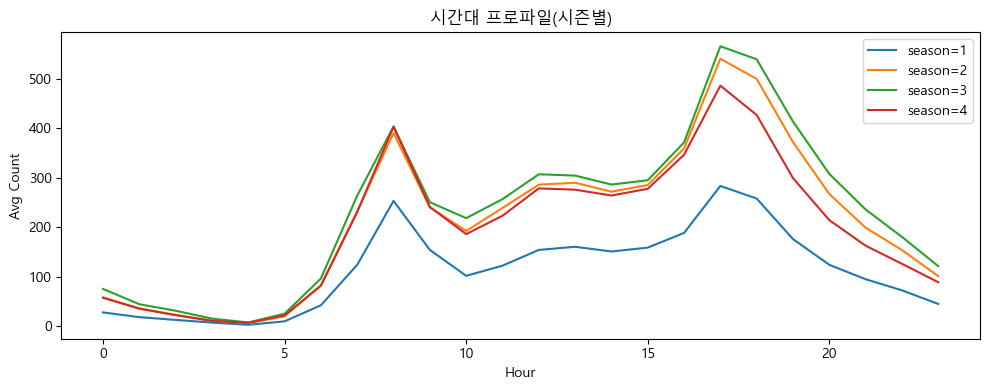

In [15]:
def hourly_profile_by_season(df_reset: pd.DataFrame) -> None:
    fig_data = {}
    for s in sorted(df_reset['season'].unique()):
        sub = df_reset[df_reset['season'] == s]
        prof = sub.groupby('hour')['count'].mean()
        fig_data[s] = prof

    plt.figure(figsize=(10,4))
    for s, prof in fig_data.items():
        plt.plot(prof.index, prof.values, label=f'season={s}')
    plt.title('시간대 프로파일(시즌별)')
    plt.xlabel('Hour')
    plt.ylabel('Avg Count')
    plt.legend()
    plt.tight_layout()
    plt.show()

hourly_profile_by_season(df_reset)


In [16]:
# 시즌별로 포함된 월 확인
df['month'] = df['datetime'].dt.month  # datetime 컬럼에서 월 정보 추출
season_months = df.groupby('season')['month'].unique()  # 시즌별로 고유한 월 확인

# 결과 출력
for season, months in season_months.items():
    print(f"Season {season}: Months {sorted(months)}")

Season 1: Months [np.int32(1), np.int32(2), np.int32(3)]
Season 2: Months [np.int32(4), np.int32(5), np.int32(6)]
Season 3: Months [np.int32(7), np.int32(8), np.int32(9)]
Season 4: Months [np.int32(10), np.int32(11), np.int32(12)]


#### 해설: 시즌별 시간대 프로파일
- 목적: 시즌에 따른 시간대 패턴 차이를 가시화.
- 해석:
  - 여름: 저녁 피크 강화(야외활동 증가).
  - 겨울: 전반적 레벨 하락과 피크 완화.
  - 공통: 출퇴근 피크(아침/저녁)는 대부분 시즌에서 유지.


### 13. 이상치(Outlier) 탐색 — IQR 기반

- IQR 범위를 벗어나는 상·하위 구간을 표시해 비정상 구간을 탐색합니다.
- 해석 시 맥락(날씨/이벤트/점검기간 등)을 고려해 실질적 이상인지 판단합니다.


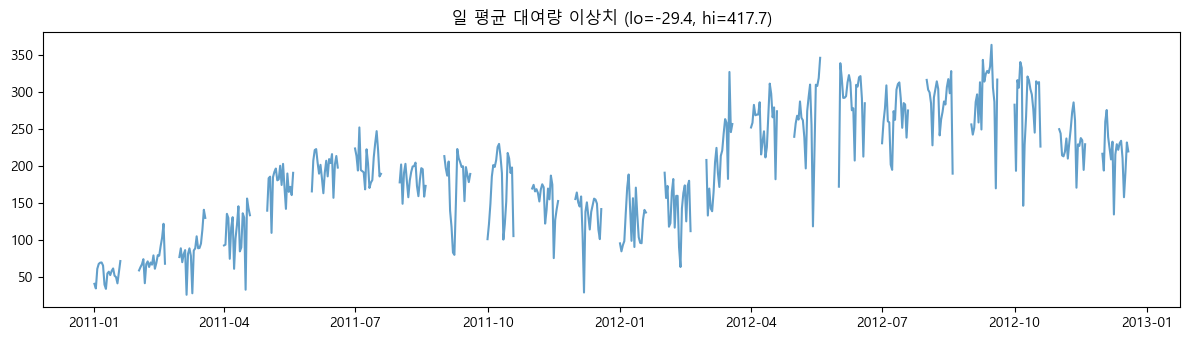

이상치 개수: 0


In [17]:
def outlier_mark(series: pd.Series, k: float = 1.5, title: str = 'IQR 기반 이상치') -> None:
    q1, q3 = np.percentile(series.dropna(), [25, 75])
    iqr = q3 - q1
    lo, hi = q1 - k*iqr, q3 + k*iqr
    mask = (series < lo) | (series > hi)
    plt.figure(figsize=(12,3.5))
    plt.plot(series.index, series.values, alpha=0.7)
    plt.scatter(series.index[mask], series.values[mask], s=10)
    plt.title(f'{title} (lo={lo:.1f}, hi={hi:.1f})')
    plt.tight_layout()
    plt.show()
    print("이상치 개수:", int(mask.sum()))

outlier_mark(daily, k=1.5, title='일 평균 대여량 이상치')


#### 해설: IQR 이상치 탐색
- 목적: 규칙적 패턴에서 벗어난 관측치 식별.
- 해석:
  - 상단 이상치: 이벤트/날씨 호조건/데이터 중복 가능.
  - 하단 이상치: 악천후/시스템 장애/데이터 유실 가능.
  - 이상치는 제거보다 ‘원인 규명 후 처리’가 바람직합니다.
    - q1, q3 = np.percentile(series.dropna(), [25, 75])   # 1사분위(Q1), 3사분위(Q3)
    - iqr = q3 - q1                                       # IQR = Q3 - Q1
    - lo = q1 - k * iqr                                   # 하한선
    - hi = q3 + k * iqr                                   # 상한선

## 추가: 정량적 시계열 진단 (ADF / STL / ACF-PACF)
EDA에서 확인한 패턴을 **통계적 지표**로 점검합니다.

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# 대상 시계열: daily (앞에서 정의된 일별 합계 시계열)
s = daily.dropna()
adf_stat, pval, _, _, crit, _ = adfuller(s.values, autolag='AIC')
print(f'ADF 통계량: {adf_stat:.3f}, p-value: {pval:.4f}')
print('임계값:', crit)
print('→ p<0.05이면 비정상성(단위근) 가설을 기각: 차분 없이도 ARIMA 가능성 ↑')


In [ ]:
# STL 분해 (요일 주기 가정: 7)
stl = STL(s, period=7, robust=True).fit()
fig = stl.plot(); fig.set_size_inches(10,6); plt.tight_layout(); plt.show()
print('→ 추세/계절/잔차 분해로 주기와 잔차의 크기 가늠')


In [ ]:
# ACF/PACF로 차수 가늠
fig1 = plt.figure(figsize=(9,3))
ax1 = fig1.add_subplot(121)
plot_acf(s, lags=40, ax=ax1)
ax2 = fig1.add_subplot(122)
plot_pacf(s, lags=40, ax=ax2)
plt.tight_layout(); plt.show()
print('→ 계절 AR/MA 가능성, 차분 필요성 힌트 얻기')


> **노트**: 이상치/결측은 정책(제거 vs 대체)을 정해서 반영하세요. 예: IQR rule로 탐지 후 인접값 보간 등.